## Process Optimization - the `Main` code 

### Fourth Batch of Bayesian Optimization based on Experimental Data produced on Nov 8, 2020
- This notebook is to run Bayesian Optimization on initial sampling data, and provide the first batch suggestion on experiment conditions
- Experiments of perovskite devices are prepared by Nick Rolston and Thomas Colburn (Stanfrod University) 
- Jupyter Notebook is prepared by Zhe Liu (Massachusetts Insititute of Technology)

In [111]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
df_all_device  = pd.read_excel("./All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
print(df_all_device.columns)
df_all_device = df_all_device.iloc[:,2:13]
df_all_device = df_all_device.dropna()
df_all_device.columns = ['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]','Film Quality?']
df_all_device

Index(['ML Condition', 'Sample', 'Temperature [°C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]',
       'Plasma DC [%]', 'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]',
       'Film Success or not?', 'Unnamed: 13', ' ', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%],Film Quality?
0,155,200,5000,1.2,35,50,16.261900,0.932514,0.39,5.914137,Yes
1,160,225,3000,0.8,30,75,2.239204,0.108900,0.25,0.060982,No
2,135,200,2500,1.0,25,75,23.176100,0.926920,0.60,12.889485,Yes
3,150,175,2000,1.0,20,100,20.804760,0.739500,0.31,4.769839,No
4,170,275,4500,1.2,16,50,21.509520,0.832600,0.66,11.820590,No
...,...,...,...,...,...,...,...,...,...,...,...
139,170,300,2500,1.0,25,100,15.171420,0.721700,0.39,4.270196,No
140,160,100,4000,1.0,25,75,15.428570,0.951900,0.49,7.196364,Yes
141,155,275,2500,1.2,35,100,5.652380,0.643600,0.43,1.564446,Yes
142,140,225,3000,1.0,20,50,21.495230,0.917800,0.72,14.204410,Yes


In [222]:
Xc

array([[0.025     , 0.625     , 0.175     , 0.425     , 0.125     ,
        0.175     ],
       [0.425     , 0.475     , 0.275     , 0.275     , 0.825     ,
        0.725     ],
       [0.475     , 0.275     , 0.725     , 0.225     , 0.775     ,
        0.275     ],
       ...,
       [0.49974898, 0.12948855, 0.49721495, 0.7495307 , 0.        ,
        0.05728732],
       [0.65898109, 0.56746504, 0.70650929, 0.93524966, 0.        ,
        0.16678053],
       [0.45817527, 0.14261248, 0.57446127, 0.85067526, 0.        ,
        0.04208859]])

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

X=df_all_device.iloc[:,:6]
y=df_all_device['Efficiency [%]']

X=X.to_numpy(dtype='float')
y=y.to_numpy(dtype='float').reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

scaler_y = StandardScaler()
scaler_y.fit(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)
y = scaler_y.transform(y)

In [114]:
#print(gb_random.best_params_)
best_params = {'subsample': 0.95, 
               'n_estimators': 105, 
               'min_samples_split': 2, 
               'min_samples_leaf': 2, 
               'max_features': 'sqrt',
               'max_depth': 4, 
               'learning_rate': 0.075,
               'alpha':0.99
               }

In [115]:
from sklearn.ensemble import GradientBoostingRegressor
GBregressor_list = []
y_pred_list = []
y_train_pred_list = []
y_test_pred_list = []
for i in np.arange(100):
    GBregressor = GradientBoostingRegressor()
    GBregressor.set_params(**best_params)
    #GBregressor.fit(X_train, y_train.ravel())
    GBregressor.fit(X, y.ravel())

    GBregressor_list.append(GBregressor)
    
    y_train_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_train).reshape(-1,1))
    y_test_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_test).reshape(-1,1))
    y_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X).reshape(-1,1))
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    y_pred_list.append(y_pred)
y_pred_mean = np.mean(y_pred_list, axis = 0)
y_train_pred_mean = np.mean(y_train_pred_list, axis = 0)
y_test_pred_mean = np.mean(y_test_pred_list, axis = 0)


train rmse: 1.0453
test rmse: 1.0066
all rmse: 1.0376
train R^2: 0.9439
test R^2: 0.9383
all R^2: 0.9430
train spearman: 0.9246
test spearman: 0.9394
all spearman: 0.9308


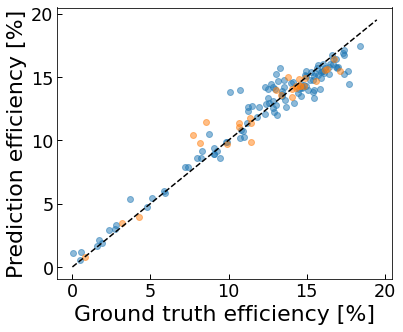

In [116]:
y_train_pred = y_train_pred_mean
y_test_pred = y_test_pred_mean
y_pred = y_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error
mse_train = mse(y_train_pred,scaler_y.inverse_transform(y_train))
mse_test = mse(y_test_pred,scaler_y.inverse_transform(y_test))
mse_all = mse(y_pred,scaler_y.inverse_transform(y))
print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(scaler_y.inverse_transform(y_train),y_train_pred)
rsquared_test = r2_score(scaler_y.inverse_transform(y_test), y_test_pred)
rsquared_all = r2_score(scaler_y.inverse_transform(y), y_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(y_train_pred,scaler_y.inverse_transform(y_train))
sprman_test = spearmanr(y_test_pred,scaler_y.inverse_transform(y_test))
sprman_all = spearmanr(y_pred,scaler_y.inverse_transform(y))
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(scaler_y.inverse_transform(y_train),y_train_pred, alpha =0.5)
plt.scatter(scaler_y.inverse_transform(y_test),y_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
yref = np.arange(0, 20, 0.5)
plt.plot(yref, yref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 5, 10, 15, 20])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

In [381]:
Xc = df_all_device.iloc[:,:6]
yc = []
for i in np.array(df_all_device.iloc[:,-1].values):
    if i == 'Yes':
        yc.append(1)
    elif i == 'No':
        yc.append(0)

Xc=Xc.to_numpy(dtype='float')
yc=np.array(yc).reshape(-1,1)

Xc_train,Xc_test,yc_train,yc_test=train_test_split(Xc,yc,test_size=0.2)

scaler_Xc = StandardScaler()
scaler_Xc.fit(Xc)
Xc_train = scaler.transform(Xc_train)
Xc_test = scaler.transform(Xc_test)
Xc = scaler.transform(Xc)

In [390]:
best_params_ = {'subsample': 0.90, 
               'n_estimators': 70, 
               'min_samples_split': 2, 
               'min_samples_leaf': 1, 
               'max_features': 'sqrt',
               'max_depth': 4, 
               'learning_rate': 0.125,
               #'alpha':0.0001
               }

In [395]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
GBclassifier_Cons_list = []
yc_pred_list = []
yc_train_pred_list = []
yc_test_pred_list = []
for i in np.arange(100):
    GBclassifier_Cons = GradientBoostingClassifier()
    GBclassifier_Cons.set_params(**best_params_)
    GBclassifier_Cons.fit(Xc_train, yc_train.ravel())
    GBclassifier_Cons.fit(Xc, yc.ravel())
    GBclassifier_Cons_list.append(GBclassifier_Cons)
    
    yc_train_pred=GBclassifier_Cons_list[i].predict_proba(Xc_train)[:,1]
    yc_test_pred=GBclassifier_Cons_list[i].predict_proba(Xc_test)[:,1]
    yc_pred=GBclassifier_Cons_list[i].predict_proba(Xc)[:,1]
    yc_train_pred_list.append(yc_train_pred)
    yc_test_pred_list.append(yc_test_pred)
    yc_pred_list.append(yc_pred)
yc_pred_mean = np.mean(yc_pred_list, axis = 0)
yc_train_pred_mean = np.mean(yc_train_pred_list, axis = 0)
yc_test_pred_mean = np.mean(yc_test_pred_list, axis = 0)


train rmse: 0.0540
test rmse: 0.0929
all rmse: 0.0638
train R^2: 0.9806
test R^2: 0.9069
all R^2: 0.9708
train spearman: 0.6715
test spearman: 0.5279
all spearman: 0.6471


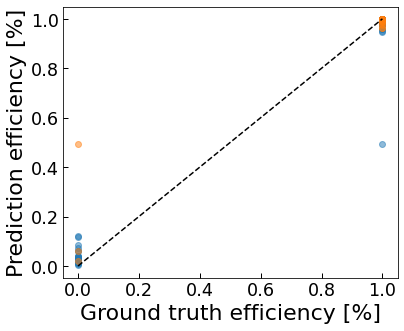

In [396]:
yc_train_pred = yc_train_pred_mean
yc_test_pred = yc_test_pred_mean
yc_pred = yc_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error
mse_train = mse(yc_train_pred,yc_train)
mse_test = mse(yc_test_pred,yc_test)
mse_all = mse(yc_pred, yc)
print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(yc_train,yc_train_pred)
rsquared_test = r2_score(yc_test, yc_test_pred)
rsquared_all = r2_score(yc, yc_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(yc_train_pred, yc_train)
sprman_test = spearmanr(yc_test_pred,yc_test)
sprman_all = spearmanr(yc_pred,yc)
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(yc_train,yc_train_pred, alpha =0.5)
plt.scatter(yc_test,yc_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
ycref = np.arange(0, 1.1, 0.1)
plt.plot(ycref, ycref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

In [254]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [125, 175, 5] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [100, 300, 25] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [2000, 5000, 500] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [15, 35, 5] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 100, 25] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [0.8, 1.2, 0.2] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temperature [\N{DEGREE SIGN}C]', 
            'Speed [mm/s]',
            'Spray Flow [uL/min]', 
            'Plamsa Height [cm]', 
            'Plasma Gas Flow [L/min]', 
            'Plasma DC [%]']

In [122]:
def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [123]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

# parameter_space = ParameterSpace([ContinuousParameter('temp', 0-1/(temp_num-1)/2, 1+1/(temp_num-1)/2),
#                                  ContinuousParameter('speed', 0-1/(speed_num-1)/2, 1+1/(speed_num-1)/2),
#                                  ContinuousParameter('sprayFL', 0-1/(sprayFL_num-1)/2, 1+1/(sprayFL_num-1)/2),
#                                  ContinuousParameter('plamsaH', 0-1/(plasmaH_num-1)/2, 1+1/(plasmaH_num-1)/2),
#                                  ContinuousParameter('gasFL', 0-1/(gasFL_num-1)/2, 1+1/(gasFL_num-1)/2),
#                                  ContinuousParameter('plasmaDC', 0-1/(plasmaDC_num-1)/2, 1+1/(plasmaDC_num-1)/2)
#                                  ])


parameter_space = ParameterSpace([ContinuousParameter('temp', 0,1),
                                 ContinuousParameter('speed', 0,1),
                                 ContinuousParameter('sprayFL', 0,1),
                                 ContinuousParameter('plamsaH', 0,1),
                                 ContinuousParameter('gasFL', 0,1),
                                 ContinuousParameter('plasmaDC', 0,1)
                                 ])

In [124]:
df_thiswork  = pd.read_excel("./All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
df_thiswork = df_thiswork.iloc[:99,0:13]
thiswork_device = df_thiswork['Film Success or not?'] == 'Yes'

In [125]:
df_thiswork[thiswork_device].iloc[:,2:-1]

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,155,200,5000,1.2,35,50,16.2619,0.932514,0.39,5.914137
2,135,200,2500,1.0,25,75,23.1761,0.926920,0.60,12.889485
6,140,150,4000,1.0,20,75,19.9090,1.023000,0.69,14.053536
8,130,175,3500,0.8,25,75,21.8800,1.044000,0.74,16.904349
9,135,125,2500,1.2,20,25,22.0476,1.025000,0.71,16.045155
...,...,...,...,...,...,...,...,...,...,...
94,140,150,3500,1.2,20,50,19.7860,1.021000,0.79,15.959000
95,140,150,3500,1.0,20,50,18.9330,0.978000,0.58,10.739000
96,145,125,3000,1.2,16,50,22.7520,0.987000,0.74,16.621000
97,150,175,3500,1.0,16,50,26.4330,0.978000,0.58,14.988000


### Load the previous experimental data

In [173]:
df_previous

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
180    0.0
181    0.0
182    0.0
183    0.0
184    0.0
Name: Br content, Length: 185, dtype: float64

In [228]:
df_previous  = pd.read_excel("./new_plamsa_previous_selected_20200927.xlsx", sheet_name= "Sheet1")
df_previous.iloc[:,2] = df_previous.iloc[:,2] /10
df_previous.iloc[:,3] = df_previous.iloc[:,3] /1000
df_previous = df_previous.iloc[:,:11]
print(df_previous.columns)
df_previous.columns = ['', 'Temperature [\N{DEGREE SIGN}C]', 'Speed [cm/s]',
       'Spray Flow [mL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_previous = df_previous.sort_values(by=list(df_previous.iloc[:,[1,2,3,4,5,6,-1]].columns), ignore_index = True)
# df_previous = df_previous.drop_duplicates(['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
#        'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]'], keep = 'last', ignore_index = True)
df_previous = df_previous.iloc[:,1:]
df_previous

Index(['Unnamed: 0', 'Temp [degC]', 'speed [mm/s]', 'sprayFL [uL/min]',
       'plamsaH [cm]', 'gasFL [L/min]', 'plasmaDC [%]', 'Jsc [mA/cm2]',
       'Voc [V]', 'FF [-]', 'Efficiency [%]'],
      dtype='object')


,Temperature [°C],Speed [cm/s],Spray Flow [mL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,125,10.0,2.5,1.5,15,100,0.763209,16.678352,0.561663,7.1494
1,125,10.0,2.5,1.5,15,100,0.764307,16.693951,0.594879,7.5902
2,125,15.0,3.0,1.0,15,100,0.777895,22.145733,0.589384,10.1534
3,125,15.0,3.0,1.0,15,100,0.933930,21.041220,0.661820,13.0054
4,135,10.0,2.5,1.0,15,100,0.780622,18.418326,0.593654,8.5354
...,...,...,...,...,...,...,...,...,...,...
61,145,20.0,5.0,1.0,15,100,0.966357,19.217004,0.682210,12.6690
62,145,20.0,5.0,1.0,15,100,0.957637,19.597432,0.728667,13.6751
63,150,10.0,3.5,1.0,15,100,0.966984,19.472074,0.628517,11.8345
64,150,10.0,3.5,1.0,15,100,0.937632,20.745524,0.676690,13.1627


### Define the Probabilistic Constrained Bayesian Optimization Loop
- This Optimization loop takes in two contraint functions (one for binary film quality; one for previous device data)
- The data for constraint function is converted into a probablistic constraint (with a scaling factor spec the contraint strength on the acquisition function)

In [229]:
from typing import Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization import AcquisitionOptimizerBase
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition
from emukit.bayesian_optimization.local_penalization_calculator import LocalPenalizationPointCalculator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      MultipointExpectedImprovement,\
                                                      ProbabilityOfFeasibility
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

class ProbabilisticConstraintBayesianOptimizationLoop2(OuterLoop):
    def __init__(self, space: ParameterSpace, model_objective: Union[IModel, IDifferentiable],
                 model_constraint1: Union[IModel, IDifferentiable], 
                 model_constraint2: Union[IModel, IDifferentiable],
                 acquisition: Acquisition = None,
                 update_interval: int = 1, batch_size: int = 1):

        """
        Emukit class that implements a loop for building Bayesian optimization with an unknown constraint.
        For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param space: Input space where the optimization is carried out.
        :param model_objective: The model that approximates the underlying objective function
        :param model_constraint: The model that approximates the unknown constraints
        :param acquisition: The acquisition function for the objective function (default, EI).
        :param update_interval:  Number of iterations between optimization of model hyper-parameters. Defaults to 1.
        :param batch_size: How many points to evaluate in one iteration of the optimization loop. Defaults to 1.
        """

#         if not np.all(np.isclose(model_objective.X, model_constraint.X)):
#             raise ValueError('Emukit currently only supports identical '
#                              'training inputs for the constrained and objective model')
        self.model_objective = model_objective
        self.model_constraint1 = model_constraint1
        self.model_constraint2 = model_constraint2
        
        if acquisition is None:
            acquisition = ExpectedImprovement(model_objective)
        
        acquisition_constraint1 = ScaledProbabilityOfFeasibility(model_constraint1, max_value = 1, min_value = 0.5)
        acquisition_constraint2 = ScaledProbabilityOfFeasibility(model_constraint2, max_value = 1, min_value = 0.8)
        acquisition_constraint = acquisition_constraint1*acquisition_constraint2
        acquisition_constrained = acquisition * acquisition_constraint

        model_updater_objective = FixedIntervalUpdater(model_objective, update_interval)
        model_updater_constraint1 = FixedIntervalUpdater(model_constraint1, update_interval,
                                                        lambda state: state.Y_constraint1)
        model_updater_constraint2 = FixedIntervalUpdater(model_constraint2, update_interval,
                                                        lambda state: state.Y_constraint2)

        acquisition_optimizer = GradientAcquisitionOptimizer(space)
        if batch_size == 1:
            candidate_point_calculator = SequentialPointCalculator(acquisition_constrained, acquisition_optimizer)
        else:
            
            log_acquisition = LogAcquisition(acquisition_constrained)
            candidate_point_calculator = LocalPenalizationPointCalculator(log_acquisition, acquisition_optimizer,
                                                                          model_objective, space, batch_size)
        loop_state = create_loop_state(model_objective.X, model_objective.Y)
        
        #loop_state = create_loop_state(model_objective.X, model_objective.Y, Y_constraint=model_constraint.Y)

        super(ProbabilisticConstraintBayesianOptimizationLoop2, self).__init__(candidate_point_calculator,
                                                                              [model_updater_objective, model_updater_constraint1,model_updater_constraint2],
                                                                              loop_state)
#     def suggest_next_locations(self):
#         return self.candidate_point_calculator.compute_next_points(self.loop_state)
    
#     def acquisition_evaluate(self, X: loop_sate.X):
#         return acquisition.evaluate(X), acquisition_constraint.evaluate(X), acquisition_constrained.evaluate(X)


In [230]:
from typing import Tuple, Union
import scipy.stats
import numpy as np
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable

class ScaledProbabilityOfFeasibility(Acquisition):

    def __init__(self, model: Union[IModel, IDifferentiable], jitter: float = float(0),
                 max_value: float = float(1), min_value: float = float(0)) -> None:
        """
        This acquisition computes for a given input point the probability of satisfying the constraint
        C<0. For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param model: The underlying model that provides the predictive mean and variance for the given test points
        :param jitter: Jitter to balance exploration / exploitation
        """
        self.model = model
        self.jitter = jitter
        self.max_value = max_value
        self.min_value = min_value

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: numpy array with the probability of satisfying the constraint at the points x.
        """
        mean, variance = self.model.predict(x)
        mean += self.jitter

        standard_deviation = np.sqrt(variance)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        return cdf*(self.max_value-self.min_value)+self.min_value

    def evaluate_with_gradients(self, x: np.ndarray) -> Tuple:
        """
        Computes the  probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: tuple of numpy arrays with the probability of satisfying the constraint at the points x 
        and its gradient.
        """
        mean, variance = self.model.predict(x)
        standard_deviation = np.sqrt(variance)

        dmean_dx, dvariance_dx = self.model.get_prediction_gradients(x)
        dstandard_devidation_dx = dvariance_dx / (2 * standard_deviation)

        mean += self.jitter
        u = - mean / standard_deviation
        pdf = scipy.stats.norm.pdf(0, mean, standard_deviation)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        dcdf_dx = - pdf * (dmean_dx + dstandard_devidation_dx * u)

        return cdf*(self.max_value-self.min_value)+self.min_value, dcdf_dx

    @property
    def has_gradients(self):
        return isinstance(self.model, IDifferentiable)

### Run GP Regression on the Experimental Data
- Experimental device data for round 0 initial sampling and round 1 experiments: device efficiency
- Experimental film data for round 0 initial sampling and round 1 experiments: binary film quality
- Previous experiment data of the "new plasma" nozzle: device efficiency

### Start the First Run of the Batch-mode Bayesian Optimization 

In [426]:
#np.random.seed(10)
import emukit
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

#from sklearn.preprocessing import StandardScaler

BO_list_wInitCons = []
for n in np.arange(100):
    design = LatinDesign(parameter_space)
    x_LHS = design.get_samples(20)
    x_init = x_denormalizer(x_LHS)

    y_hat_list = []
    for i in np.arange(len(GBregressor_list)):
        y_hat = GBregressor_list[i].predict(scaler.transform(x_init))
        y_hat_list.append(y_hat)
    y_hat_mean = np.mean(y_hat_list, axis = 0)
    y_pred_init = scaler_y.inverse_transform(y_hat_mean)


    yc_hat_list = []
    for i in np.arange(len(GBclassifier_Cons_list)):
        yc_hat = GBclassifier_Cons_list[i].predict_proba(scaler_Xc.transform(x_init))
        yc_hat_list.append(yc_hat[:,1])
    yc_hat_mean = np.mean(yc_hat_list, axis = 0)
    yc_pred_init = yc_hat_mean


    Xc = x_normalizer(x_init)
    Yc = np.transpose([np.around(yc_pred_init)])
    X = []
    Y = []
    for i in np.arange(len(Yc)):
        if Yc[i]>=0.5:
            X.append(Xc[i])
            Y.append(y_pred_init[i])

    X = np.array(X)
    Y = np.transpose([Y])    


    input_dim = len(X[0])
    ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
    ker.lengthscale.constrain_bounded(1e-1, 1)
    ker.variance.constrain_bounded(1e-1, 1000.0)
    # ker += GPy.kern.White(input_dim = input_dim)
    # ker += GPy.kern.Bias(input_dim = input_dim)
    model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
    # model_gpy.Gaussian_noise.variance = 1.5**2
    # model_gpy.Gaussian_noise.variance.fix()
    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
    objective_model = GPyModelWrapper(model_gpy)
    

    input_dim = len(Xc[0])
    ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)
    ker.lengthscale.constrain_bounded(1e-1, 1)#upper bound set to 1 
    ker.variance.constrain_bounded(1e-1, 1000.0) 
    #ker += GPy.kern.White(input_dim = input_dim)
    yc_offset = 0.5 # constraint acquisition computes the probability of <0
    gpy_constraint_model = GPRegression(Xc, -(Yc-yc_offset), ker) #Emukit is a minimization tool; need to make Y negative;
    # gpy_constraint_model.Gaussian_noise.variance = 0.1**2
    # gpy_constraint_model.Gaussian_noise.variance.fix()
    gpy_constraint_model.randomize()
    gpy_constraint_model.optimize_restarts(num_restarts=20,verbose =False, messages=False) 
    constraint_model1 = GPyModelWrapper(gpy_constraint_model)
    
    
    Xc2 = x_normalizer(df_previous.iloc[:,0:6].values)
    Yc2 = np.transpose([df_previous.iloc[:,-1].values])
    input_dim = len(Xc2[0])
    ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
    ker.lengthscale.constrain_bounded(1e-1, 1)#avoid overfitting; use a large lower bound
    ker.variance.constrain_bounded(1e-1, 1000.0)
    #ker += GPy.kern.White(input_dim = input_dim)
    yc2_offset = np.mean(Yc2)  # constraint acquisition computes the probability of <0
    gpy_constraint_model2 = GPRegression(Xc2 , -(Yc2-yc2_offset), ker) #Emukit is a minimization tool; need to make Y negative;
    gpy_constraint_model2.randomize()
    gpy_constraint_model2.optimize_restarts(num_restarts=20,verbose =False, messages=False)
    constraint_model2 = GPyModelWrapper(gpy_constraint_model2)

    from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
    from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement


    ## Expeceted Improvement (EI)
    ## acquisition = ExpectedImprovement(objective_model, jitter=.1)
    ## Lower Confidence Bound (LCB)
    acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)
    ## Maximum Value Entropy Search (MES)
    # acquisition = MaxValueEntropySearch(objective_model, parameter_space, grid_size = 10000*6)

    ## fully integreated acquisition
    # #acquisition_generator = lambda m: ExpectedImprovement(m, jitter=.1)
    # acquisition_generator = lambda m: NegativeLowerConfidenceBound(m, beta = 1)
    # acquisition_integrated = IntegratedHyperParameterAcquisition(objective_model, acquisition_generator)
    # acquisition = acquisition_integrated

    # Make loop and collect points
    bayesopt= ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size = 20)#batchsize>20 to account for duplication

    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    f_acq = bayesopt.candidate_point_calculator.acquisition.acquisition.evaluate

    print('total condition no.:', len(Xc))
    print('total device no.:', len(bayesopt.loop_state.Y))
    print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt.loop_state.Y, 2))))

    X_all = x_denormalizer(np.append(Xc, X_new,axis = 0))

    y_hat_list = []
    for i in np.arange(len(GBregressor_list)):
        y_hat = GBregressor_list[i].predict(scaler.transform(X_all))
        y_hat_list.append(y_hat)
    y_hat_mean = np.mean(y_hat_list, axis = 0)
    y_all_pred = scaler_y.inverse_transform(y_hat_mean)


    yc_hat_list = []
    for i in np.arange(len(GBclassifier_Cons_list)):
        yc_hat = GBclassifier_Cons_list[i].predict_proba(scaler_Xc.transform(X_all))
        yc_hat_list.append(yc_hat[:,1])
    yc_hat_mean = np.mean(yc_hat_list, axis = 0)
    yc_all_pred = yc_hat_mean

    df_Xall = pd.DataFrame(X_all, columns = df_thiswork.columns[2:8])
    df_Xall['Efficiency [%]'] = y_all_pred
    df_Xall['Film Quality [0-1]'] = np.around(yc_all_pred)


    for i in np.arange(2):

        Xc = x_normalizer(df_Xall.iloc[:,:6].values)
        Yc = np.transpose([df_Xall['Film Quality [0-1]'].values])

        X = []
        Y = []
        for i in np.arange(len(Yc)):
            if Yc[i]>=0.5:
                X.append(Xc[i])
                Y.append(df_Xall['Efficiency [%]'].values[i])

        X = np.array(X)
        Y = np.transpose([Y])


        input_dim = len(X[0])
        ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
        ker.lengthscale.constrain_bounded(1e-1, 1)
        ker.variance.constrain_bounded(1e-1, 1000.0)
        # ker += GPy.kern.White(input_dim = input_dim)
        # ker += GPy.kern.Bias(input_dim = input_dim)
        model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
    #     model_gpy.Gaussian_noise.variance = 1.5**2
    #     model_gpy.Gaussian_noise.variance.fix()
        model_gpy.randomize()
        model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
        objective_model = GPyModelWrapper(model_gpy)
        
        
        input_dim = len(Xc[0])
        ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)
        ker.lengthscale.constrain_bounded(1e-1, 1)#upper bound set to 1 
        ker.variance.constrain_bounded(1e-1, 1000.0) 
        #ker += GPy.kern.White(input_dim = input_dim)
        yc_offset = 0.5 # constraint acquisition computes the probability of <0
        gpy_constraint_model = GPRegression(Xc, -(Yc-yc_offset), ker) #Emukit is a minimization tool; need to make Y negative;
        # gpy_constraint_model.Gaussian_noise.variance = 0.1**2
        # gpy_constraint_model.Gaussian_noise.variance.fix()
        gpy_constraint_model.randomize()
        gpy_constraint_model.optimize_restarts(num_restarts=20,verbose =False, messages=False) 
        constraint_model1 = GPyModelWrapper(gpy_constraint_model)

        from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
        from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement


        ## Expeceted Improvement (EI)
        ## acquisition = ExpectedImprovement(objective_model, jitter=.1)
        ## Lower Confidence Bound (LCB)
        acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)
        ## Maximum Value Entropy Search (MES)
        # acquisition = MaxValueEntropySearch(objective_model, parameter_space, grid_size = 10000*6)

        ## fully integreated acquisition
        # #acquisition_generator = lambda m: ExpectedImprovement(m, jitter=.1)
        # acquisition_generator = lambda m: NegativeLowerConfidenceBound(m, beta = 1)
        # acquisition_integrated = IntegratedHyperParameterAcquisition(objective_model, acquisition_generator)
        # acquisition = acquisition_integrated

        # Make loop and collect points
        bayesopt= ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size = 20)#batchsize>20 to account for duplication

        X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
        f_acq = bayesopt.candidate_point_calculator.acquisition.acquisition.evaluate

        print('total condition no.:', len(Xc))
        print('total device no.:', len(bayesopt.loop_state.Y))
        print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt.loop_state.Y, 2))))
        
        
        X_all = x_denormalizer(np.append(Xc, X_new, axis = 0))

        y_hat_list = []
        for i in np.arange(len(GBregressor_list)):
            y_hat = GBregressor_list[i].predict(scaler.transform(X_all))
            y_hat_list.append(y_hat)
        y_hat_mean = np.mean(y_hat_list, axis = 0)
        y_all_pred = scaler_y.inverse_transform(y_hat_mean)


        yc_hat_list = []
        for i in np.arange(len(GBclassifier_Cons_list)):
            yc_hat = GBclassifier_Cons_list[i].predict_proba(scaler_Xc.transform(X_all))
            yc_hat_list.append(yc_hat[:,1])
        yc_hat_mean = np.mean(yc_hat_list, axis = 0)
        yc_all_pred = yc_hat_mean

        df_Xall = pd.DataFrame(X_all, columns = df_thiswork.columns[2:8])
        df_Xall['Efficiency [%]'] = y_all_pred
        df_Xall['Film Quality [0-1]'] = np.around(yc_all_pred)


    BO_eff_seq = []
    for i in np.arange(len(df_Xall['Film Quality [0-1]'].values)):
        if df_Xall['Film Quality [0-1]'].values[i]>=0.5:
            BO_eff_seq.append(df_Xall['Efficiency [%]'].values[i])
    BO_eff_seq = np.array(BO_eff_seq)   
    
    print('total condition no.:', len(df_Xall))
    print('total device no.:', len(BO_eff_seq))
    print('maximum Y (PCE [%]): ', np.round(max(BO_eff_seq), 2))

    BO_list_wInitCons.append(BO_eff_seq)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 5
total device no.: 4
maximum Y (PCE [%]):  11.47


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 10
total device no.: 9
maximum Y (PCE [%]):  14.67


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


total condition no.: 30
total device no.: 29
maximum Y (PCE [%]):  15.56
total condition no.: 50
total device no.: 49
maximum Y (PCE [%]):  15.94


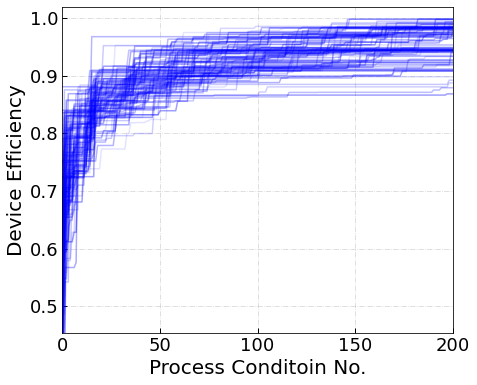

In [300]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
max_eff = 17.66
i = 0
for df_i in BO_list_wInitCons:
    eff_max_acc = np.maximum.accumulate(df_i)
    eff_acc = df_i
    i = i +1
    ax.plot(range(len(eff_max_acc)),eff_max_acc/max_eff, alpha = 0.3*i/len(BO_list_wInitCons)+0.1, c = 'blue')
#plt.scatter(range(len(eff_max_acc)),eff_acc)

#axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
#axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/max_eff,18/max_eff)
axes.set_xlim(0,200)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

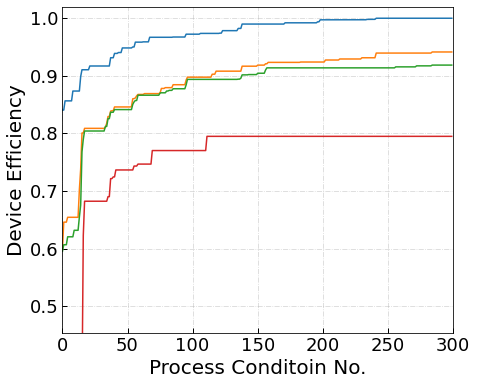

In [330]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
max_eff = 17.66
ax.plot(np.maximum.accumulate(np.percentile(BO_list_wInitCons_1, 99, axis = 0))/max_eff)

ax.plot(np.maximum.accumulate(np.median(BO_list_wInitCons_1, axis = 0))/max_eff)

ax.plot(np.maximum.accumulate(np.mean(BO_list_wInitCons_1, axis = 0))/max_eff)

ax.plot(np.maximum.accumulate(np.percentile(BO_list_wInitCons_1, 1, axis = 0))/max_eff)


axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/max_eff,18/max_eff)
axes.set_xlim(0,300)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

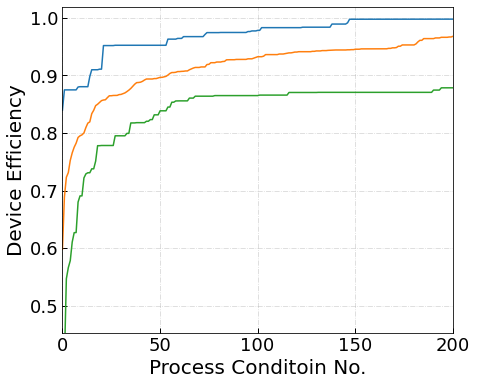

In [332]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
i = 0
eff_max_runlist = []
for df_i in BO_list_wInitCons_1:
    eff_max_acc = np.maximum.accumulate(df_i)
    eff_acc = df_i
    i = i +1
    #ax.plot(range(len(eff_max_acc)),eff_max_acc/np.max(BO_list_wInitCons), alpha = 0.3*i/len(BO_list_wInitCons)+0.1, c = 'blue')
    eff_max_runlist.append(eff_max_acc/np.max(BO_list_wInitCons_1))
#plt.scatter(range(len(eff_max_acc)),eff_acc)
ax.plot(np.percentile(eff_max_runlist, 99, axis = 0))
#ax.plot(np.percentile(eff_max_runlist, 99, axis = 0))
ax.plot(np.percentile(eff_max_runlist, 50, axis = 0))
ax.plot(np.percentile(eff_max_runlist, 1, axis = 0))

#axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
#axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/np.max(BO_list_wInitCons_1),18/np.max(BO_list_wInitCons_1))
axes.set_xlim(0,200)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

In [333]:
BO_list_df = pd.DataFrame(np.transpose(BO_list_wInitCons_1))
BO_list_df.to_excel("BO_benckmark_withCons_20210706.xls")
BO_list_df

 <ipython-input-333-7ae390bb01c2>:2: FutureWarning:As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,12.201313,13.712693,11.153217,5.315065,13.897195,8.642663,13.870527,10.115736,7.881224,14.385108,...,13.961634,11.132174,7.600625,12.777020,7.374387,4.522811,11.504819,13.227543,9.333193,10.805489
1,14.768887,11.912765,10.931192,11.576504,11.527293,14.743358,5.875440,10.283527,13.669702,13.759609,...,13.920017,2.479230,10.904189,10.595799,14.797669,5.959077,8.400101,12.550235,12.464646,7.590834
2,10.925900,8.929510,7.420144,12.617804,12.304849,14.837630,10.638832,11.638425,12.372296,6.380983,...,12.431174,12.802678,12.025858,13.164217,9.094525,14.664594,12.753490,10.774727,6.799989,6.341148
3,10.071057,12.746888,11.692451,12.871158,3.731238,11.575294,8.953690,11.192504,7.830566,10.599334,...,10.323818,9.142101,11.396626,10.387514,10.345998,11.128913,14.682839,8.871889,10.651820,9.893626
4,11.964811,12.497708,12.419053,7.878981,13.680428,9.985023,12.251304,3.750979,10.439803,12.960628,...,7.266182,10.452032,10.363064,12.173876,11.313885,7.969186,10.882195,14.225626,11.898051,3.865538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,16.320477,14.096039,14.728757,13.095329,13.513446,14.631667,16.867896,14.999075,14.711052,14.377565,...,16.903458,16.565423,13.073207,16.830702,16.580180,14.895613,15.987435,16.712647,16.648933,15.571051
296,16.310004,11.548266,13.443018,16.008065,13.339060,17.085176,16.349990,15.179094,16.681261,16.656339,...,16.851066,17.246217,15.585917,14.875546,14.661950,15.174374,15.057458,17.482237,15.843420,17.636641
297,17.377924,15.586021,14.801733,15.952864,15.832643,15.180576,17.373603,14.751258,16.664037,15.638990,...,17.011750,15.229559,15.559685,15.984523,15.609714,14.896299,15.971861,16.743088,16.018675,17.634022
298,16.837101,14.136975,15.022716,15.690651,15.595892,17.135905,17.370880,13.978107,16.664037,16.649753,...,15.103071,14.794877,15.208728,15.320246,15.252657,15.890911,15.304745,17.427475,16.169973,17.663877
